# Unsupervised Clustering

Clustering algorithms on two feature representations:

1. **Structured variables** (entity counts, symptoms, flags)
2. **Text embeddings** from SentenceTransformers (or TF-IDF fallback)
3. **Hybrid representation**: embeddings + structured features

Evaluation metrics:
- Silhouette Score
- Davies-Bouldin Index
- Calinski-Harabasz Score

Visualize results with PCA.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import warnings
warnings.filterwarnings('ignore')

In [16]:
csv_path = "ibd_ner_features_final.csv"
df = pd.read_csv(csv_path)
df.head()

,id,text_x,entities_bert,entities_spacy,entities_scispacy_bc5cdr,n_entities_scispacy_bc5cdr,n_entities_spacy,n_entities_bert,has_blood,has_diarrhea,has_pain,has_fever,has_weight_loss,n_symptom,temporal_recent,has_er,has_procedure
0,dflwn,likely frontpage subreddit glad exist want rea...,[],"[(158, 163, 'DATE', '3 day'), (369, 378, 'PERS...","[(451, 469, 'DISEASE', 'ulcerative colitis'), ...",4,4,0,0,0,0,0,0,0,0,1,1
1,dfyy1,mayo clinic article crohn s disease,[],"[(0, 27, 'ORG', 'mayo clinic article crohn s')]","[(23, 62, 'DISEASE', ""Crohn's Disease. Mayo Cl...",2,1,0,0,0,0,0,0,0,0,0,0
2,dfz1m,take remicade think help,[],[],"[(27, 35, 'CHEMICAL', 'Remicade'), (105, 113, ...",2,0,0,0,0,0,0,0,0,0,0,0
3,dh6zd,like title say ama,[],[],"[(21, 35, 'DISEASE', 'Crohns Disease')]",1,0,0,0,0,0,0,0,0,0,0,0
4,dhgot,small bowel resection appendectomy 6 year ago ...,[],"[(35, 45, 'DATE', '6 year ago')]","[(66, 87, 'DISEASE', 'small bowel resection'),...",2,1,0,0,0,0,0,0,0,0,0,1


## Structured Features

In [3]:
numeric_cols = [
    'n_entities_scispacy_bc5cdr', 'n_entities_spacy', 'n_entities_bert',
    'has_blood','has_diarrhea','has_pain','has_fever','has_weight_loss',
    'n_symptom','temporal_recent','has_er','has_procedure'
]

df_struct = df[numeric_cols].fillna(0)
scaler = StandardScaler()
X_struct = scaler.fit_transform(df_struct)

## Embeddings (SentenceTransformers or TF-IDF fallback)

In [4]:
try:
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(df['text_x'].astype(str).tolist(), show_progress_bar=True)
    print("Using SentenceTransformers embeddings.")
except Exception:
    print("SentenceTransformers not available — using TF-IDF fallback.")
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer = TfidfVectorizer(max_features=2000)
    embeddings = vectorizer.fit_transform(df['text_x'].astype(str)).toarray()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/5743 [00:00<?, ?it/s]

Using SentenceTransformers embeddings.


## Hybrid Representation (Embeddings + Structured Variables)

In [5]:
from sklearn.preprocessing import MinMaxScaler
hybrid_scaler = MinMaxScaler()
X_hybrid = np.hstack([
    embeddings,
    hybrid_scaler.fit_transform(df_struct)
])

X_hybrid.shape

(183747, 396)

In [6]:
def evaluate_clusters(X, labels):
    return {
        'silhouette': silhouette_score(X, labels),
        'davies_bouldin': davies_bouldin_score(X, labels),
        'calinski_harabasz': calinski_harabasz_score(X, labels)
    }

def run_all_clustering(X, name=""):
    results = {}

    # --- KMEANS ---
    km = KMeans(n_clusters=3, random_state=42)
    labels_km = km.fit_predict(X)
    results['kmeans'] = evaluate_clusters(X, labels_km)

    # --- GMM ---
    gmm = GaussianMixture(n_components=3, random_state=42)
    labels_gmm = gmm.fit_predict(X)
    results['gmm'] = evaluate_clusters(X, labels_gmm)

    return results

## Execute models

In [7]:
results_struct = run_all_clustering(X_struct)
results_emb = run_all_clustering(embeddings)
results_hybrid = run_all_clustering(X_hybrid)

results_struct, results_emb, results_hybrid

({'kmeans': {'silhouette': np.float64(0.5796164684684856),
   'davies_bouldin': np.float64(1.4087749612914402),
   'calinski_harabasz': np.float64(36329.25056194341)},
  'gmm': {'silhouette': np.float64(0.5791691847834163),
   'davies_bouldin': np.float64(1.3954904740544742),
   'calinski_harabasz': np.float64(36201.17775569177)}},
 {'kmeans': {'silhouette': np.float32(0.1404465),
   'davies_bouldin': np.float64(3.159682323745489),
   'calinski_harabasz': np.float32(20926.096)},
  'gmm': {'silhouette': np.float32(0.14624356),
   'davies_bouldin': np.float64(3.5243626079560255),
   'calinski_harabasz': np.float32(19611.414)}},
 {'kmeans': {'silhouette': np.float64(0.22066641659967082),
   'davies_bouldin': np.float64(1.8726935251959216),
   'calinski_harabasz': np.float64(21218.53569192217)},
  'gmm': {'silhouette': np.float64(0.11253902153570637),
   'davies_bouldin': np.float64(2.8373087260180347),
   'calinski_harabasz': np.float64(17263.014549465046)}})

## Metrics

In [8]:
df_results = pd.DataFrame({
    'structured': results_struct,
    'embeddings': results_emb,
    'hybrid': results_hybrid
}).T

df_results

,kmeans,gmm
structured,"{'silhouette': 0.5796164684684856, 'davies_bou...","{'silhouette': 0.5791691847834163, 'davies_bou..."
embeddings,"{'silhouette': 0.1404465, 'davies_bouldin': 3....","{'silhouette': 0.14624356, 'davies_bouldin': 3..."
hybrid,"{'silhouette': 0.22066641659967082, 'davies_bo...","{'silhouette': 0.11253902153570637, 'davies_bo..."


## PCA Visualization (2D)

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca(X, labels, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(7,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', s=12)
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

### Plot clusters for each representation

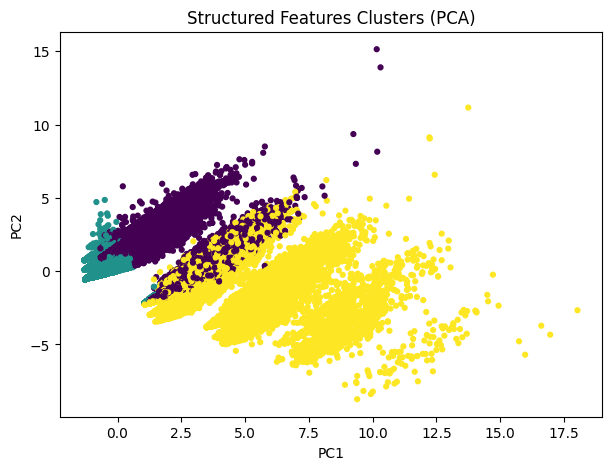

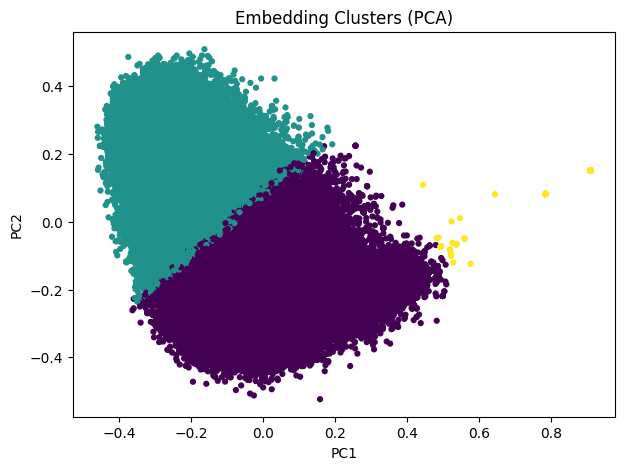

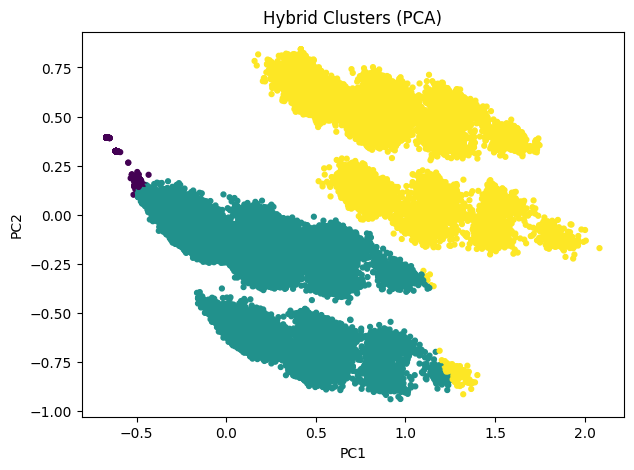

In [10]:
km_struct = KMeans(n_clusters=3).fit_predict(X_struct)
km_emb = KMeans(n_clusters=3).fit_predict(embeddings)
km_hybrid = KMeans(n_clusters=3).fit_predict(X_hybrid)

plot_pca(X_struct, km_struct, "Structured Features Clusters (PCA)")
plot_pca(embeddings, km_emb, "Embedding Clusters (PCA)")
plot_pca(X_hybrid, km_hybrid, "Hybrid Clusters (PCA)")

In [15]:
def build_model_table(model_name, results_struct, results_emb, results_hybrid):
    # Extraer las métricas para cada enfoque
    data = {
        'structured': results_struct[model_name],
        'embeddings': results_emb[model_name],
        'hybrid': results_hybrid[model_name]
    }

    # Convertir a DataFrame
    df = pd.DataFrame(data)
    return df

# Crear tablas individuales por modelo
df_kmeans = build_model_table('kmeans', results_struct, results_emb, results_hybrid)
df_gmm = build_model_table('gmm', results_struct, results_emb, results_hybrid)

print("K-Means Metrics:")
print(df_kmeans)
df_kmeans.to_csv("kmeans_metrics.csv")
print("\nGMM Metrics:")
print(df_gmm)
df_gmm.to_csv("gmm_metrics.csv")


K-Means Metrics:
                     structured    embeddings        hybrid
silhouette             0.579616      0.140446      0.220666
davies_bouldin         1.408775      3.159682      1.872694
calinski_harabasz  36329.250562  20926.095703  21218.535692

GMM Metrics:
                     structured    embeddings        hybrid
silhouette             0.579169      0.146244      0.112539
davies_bouldin         1.395490      3.524363      2.837309
calinski_harabasz  36201.177756  19611.414062  17263.014549
